# FashionMNIST GAN Implementation and Evaluation
============================================

This project implements and evaluates a Generative Adversarial Network (GAN) on the FashionMNIST dataset.
The implementation is based on a [Conditional GAN on MNIST](https://github.com/rtealwitter/dl-demos/blob/5c997bb7b90eca6881140dea6bb85cf0ecd623a8/demo11-conditional-gan.ipynb).

Key Components:
--------------
1. Data Handling:
   - Dataset: FashionMNIST (fashion items instead of digits)
   - Transformation: Normalize to [-1, 1] range

2. Architecture:
   
   Generator:
   - Input: Random noise (100-dimensional)
   - Hidden layers: 128 -> 256 -> 512 -> 1024
   - Output: 28x28 grayscale image
   - Activations: LeakyReLU, final Tanh

   Discriminator:
   - Input: 28x28 grayscale image
   - Hidden layers: 512 -> 256
   - Output: Single value (real/fake probability)
   - Activations: LeakyReLU, final Sigmoid

3. Training Parameters:
   - Optimizer: Adam (lr=0.0002, betas=(0.5, 0.999))
   - Loss: Binary Cross Entropy
   - Epochs: 10
   - Batch size: 64

4. Performance Metrics:
   
   Training Dynamics:
   - FIR : Measures quality and diversity of generated images by computeing distance between real and generated image distributions
   - IS : Evaluates quality and diversity of generated images based on classfication
   - Generator Loss: Measures generator's effectiveness
   - Discriminator Loss: Measures discriminator's accuracy
   - G/D Loss Ratio: Monitors training stability
   - Neural Divergence: Tracks distribution matching

   Quality Metrics:
   - Precision: Fake images correctly recognized / All images identified as fake
   - Recall: Fake images correctly recognized / All fake images

5. Key Differences from MNIST Conditional GAN:
   - Removed conditioning on class labels
   - More challenging dataset (fashion items vs digits)
   - Different evaluation metrics

6. Visualization:
   - Loss curves
   - Quality metrics over time
   - Generated sample images
   - Training progress monitoring

Note:
-----
FashionMNIST is generally more challenging than MNIST due to:
- More complex patterns and textures
- Greater intra-class variation
- Less distinct class boundaries

The removal of conditioning information makes the generation task more challenging but also more general.

---

## Libaries

As always, we load lots of libraries and we add the **torchmetrics** to do evaluation.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
%matplotlib inline

## Data

For this demo, we will be using the **FashionMNIST data** set instead.

In [2]:
# Transform to convert images to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load FashionMNIST instead of MNIST
data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

## Helper Functions

We'll need several helper functions for training the GAN but we don't need the one-hot function here since we don't need the labels as conditions.

In [3]:
def get_sample_image(G, DEVICE, n_noise=100):
    # Modified to generate a grid of random images without conditioning
    z = torch.randn(100, n_noise).to(DEVICE)
    with torch.no_grad():
        y_hat = G(z).view(100, 28, 28)
        result = y_hat.cpu().data.numpy()
    
    # Create a 10x10 grid
    img = np.zeros([280, 280])
    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            img[i*28:(i+1)*28, j*28:(j+1)*28] = result[idx]
    return img

###  Evaluation Matrics : Measures of GAN quality

#### **Frechet Inception Distance (FID)**: Measures the *quality* and *diversity* of generated images by comparing their distribution to that of real images using the Inception v3 model.

$$
FID = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
$$
Where:
- $\mu_r$ and $\mu_g$: Mean of the real and generated images’ feature vectors, respectively.
- $\Sigma_r$ and $\Sigma_g$: Covariance matrices of the real and generated images’ feature vectors.
- $\text{Tr}$: Represents the trace of a matrix, which is the sum of its diagonal elements.

##### Interpreting the FID Score
1. **Lower FID Score = Better Quality and Diversity**:
   - A **lower FID** indicates that the generated images are very close to the real images in terms of feature distribution. It means that the generator produces high-quality images with diversity that matches the real dataset.
   - In practice, a FID score close to 0 means that the generated images are almost indistinguishable from real images.
1. **Higher FID Score = Poor Quality or Mode Collapse**:
   - A **high FID** score indicates that there is a significant difference between the real and generated data distributions, implying that the generated images are of lower quality or lack diversity.
   - It could mean issues like mode collapse (when the generator fails to generate diverse images and produces limited variations).

---

#### **Inception Score (IS)**: Measures the *quality* and *diversity* of generated images based on how well they can be classified into distinct categories using the Inception v3 model.

$$
IS = \exp\left( \mathbb{E}_{x \sim p_g} \left[ D_{KL}(p(y|x) \,||\, p(y)) \right] \right)
$$

Where:
- $x \sim p_g$: A generated image sampled from the distribution of generated images.
- $p(y|x)$: The conditional label distribution predicted by the Inception v3 model for image $x$.
- $p(y)$: The marginal distribution over the labels, representing the overall distribution of predicted categories.
- $D_{KL}$: The **Kullback-Leibler (KL) divergence**, which measures how different the conditional distribution $p(y|x)$ is from the marginal distribution $p(y)$.
- $\exp$: The **exponential function**, which ensures that the Inception Score is positive.

##### Mean and Standard Deviation for Inception Score
Use code :
```python
inception_score = inception.compute()
```
We get a result like:
```python
inception_score = (mean_is, std_is)
```
- **Mean (Average IS)**: The mean Inception Score represents the **average quality and diversity** of the generated images across multiple runs. It helps provide an overall assessment of how well the generator produces realistic and diverse images.
- **Standard Deviation (Std)**: The standard deviation indicates the **variability** of the Inception Score across multiple runs. A **low standard deviation** means that the model produces images of **consistent quality**, while a **high standard deviation** suggests that the quality of the generated images varies significantly between different samples.


##### Interpreting the Inception Score
1. **Higher Inception Score = Better Quality and Diversity**:
   - A **high IS** means that the generated images are easily classifiable by the Inception model into distinct categories, indicating good quality. It also suggests that the generated images are diverse across different categories.
   - If $p(y|x)$ is highly concentrated for each generated image and $p(y)$ is spread across many categories, the IS will be high, indicating good diversity and image clarity.

2. **Lower Inception Score = Poor Quality or Mode Collapse**:
   - A **low IS** suggests that the generated images are either not clear enough to be confidently classified by the Inception model or lack diversity, meaning that the model might be generating similar images (mode collapse).
   - If $p(y|x)$ has high entropy (spread out predictions) or if $p(y)$ is not diverse, the IS will be low, indicating poor quality or low variability.

The **Inception Score** is particularly useful for evaluating the overall quality of generated images, but it does not compare the generated images directly with the real data distribution, unlike FID. Instead, it measures how well the generated images align with recognizable categories based on the Inception model's pre-trained classification ability.


We can calculate FID and IS scores using *PyTorch* or *torchmetrics*.

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize metrics
fid = FrechetInceptionDistance(feature=64).to(DEVICE) # Using 64 features provides sufficient information to capture image characteristics
inception = InceptionScore().to(DEVICE)

# Lists to store metrics
fid_scores = []
inception_means = []
inception_stds = []

### Additional Expected Balanced Matrics

#### **Generator/Discriminator Ratio (G/D Ratio)**: Measures the *balance* between the Generator and Discriminator during GAN training.

The **G/D Ratio** is computed as the ratio of the **loss** of the Generator to the **loss** of the Discriminator:

$$
G/D = \frac{L_G}{L_D}
$$

Where:
- $L_G$: The **loss** of the Generator.
- $L_D$: The **loss** of the Discriminator.

##### Interpreting the G/D Ratio
1. **Balanced G/D Ratio**:
   - A **balanced ratio** indicates that the Generator and Discriminator are learning at a similar rate. This usually means that neither is dominating the other, which is a good indicator of stable training.
  
2. **High G/D Ratio**:
   - A **high G/D ratio** (i.e., Generator loss is significantly higher than Discriminator loss) could indicate that the Discriminator is too strong. It may be classifying real vs. fake images too easily, resulting in poor Generator performance and unstable training.

3. **Low G/D Ratio**:
   - A **low G/D ratio** (i.e., Generator loss is significantly lower) could indicate that the Generator is dominating, which may lead to the Discriminator not learning effectively. This might result in **mode collapse**, where the Generator produces a limited variety of images.

The **G/D Ratio** is used to monitor the dynamics between the Generator and Discriminator, aiming to achieve a balance that helps improve the stability and convergence of GAN training.

---

#### **Neural Divergence for GANs**: Measures how well the Discriminator distinguishes between real and fake images.

##### Formula
$$
ND = \mathbb{E}_{x \sim p_{\text{real}}} [\log(D(x) + \epsilon)] + \mathbb{E}_{x \sim p_{\text{fake}}} [\log(1 - D(G(z)) + \epsilon)]
$$

Where:
- **$ND$**: Neural Divergence.
- **$D(x)$**: Discriminator's score for an input image $x$.
  - **$x \sim p_{\text{real}}$**: Represents **real images**.
  - **$x \sim p_{\text{fake}}$**: Represents **fake images** generated by the Generator.
- **$\epsilon$**: A small value (`1e-10`) for **numerical stability** to prevent taking the log of zero.


##### Interpreting Neural Diversity
1. **High Neural Diversity**:
   - **High Neural Diversity** indicates that the Discriminator is confidently distinguishing between real and fake images, suggesting effective separation between the two distributions.

2. **Low Neural Diversity**:
   - **Low Neural Diversity** indicates that the Discriminator struggles to differentiate between real and fake, meaning that the Generator may be producing more realistic images or that the Discriminator is weak.. This may imply that the Generator is producing similar or repetitive images, often indicative of **mode collapse**.

The goal is to achieve a **balanced Neural Divergence**, where the **Discriminator** is strong enough to provide meaningful feedback, but not too strong to overpower the **Generator**. This balance ensures effective co-training between the Generator and Discriminator, leading to better image quality and diversity.

In [5]:
def compute_neural_divergence(real_scores, fake_scores):
    """Compute neural divergence using discriminator outputs"""
    return torch.mean(torch.log(real_scores + 1e-10)).item() + \
           torch.mean(torch.log(1 - fake_scores + 1e-10)).item()

#### **Precision and Recall for GANs**: Evaluates the **performance** of the Discriminator in distinguishing between real and fake images.

The **Precision** and **Recall** are computed based on the scores given by the Discriminator for **real** and **fake** images. In the given function:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives} + \epsilon}
$$

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives} + \epsilon}
$$

Where:
- **`real_scores`**: The scores assigned by the Discriminator to real images.
- **`fake_scores`**: The scores assigned by the Discriminator to fake images.
- **`threshold`**: The cutoff value used to classify an image as **real** or **fake**. Default is `0.5`.
- **True Positives**: Fake images that are correctly classified as **fake** (i.e., `fake_scores < threshold`).
- **False Positives**: Fake images that are incorrectly classified as **real** (i.e., `fake_scores >= threshold`).
- **False Negatives**: Real images that are incorrectly classified as **fake** (i.e., `real_scores < threshold`).
- **$\epsilon$**: A small value (`1e-8`) added to prevent division by zero.

##### Interpreting Precision and Recall
1. **Precision**:
   - **Precision** measures the proportion of correctly classified **fake images** out of all images classified as **fake**.
   - A **high precision** means that the Discriminator is **accurate** when it decides an image is fake, indicating that it rarely makes mistakes when labeling images as fake.

2. **Recall**:
   - **Recall** measures the proportion of **correctly identified fake images** out of all the **actual fake images**.
   - A **high recall** means that the Discriminator is good at **identifying most of the fake images** generated by the Generator, indicating that it catches a majority of the fake samples.

##### Interpreting Precision and Recall
1. **High Precision, High Recall**:
   - Both **high precision** and **high recall** suggest that the Discriminator is **excellent** at distinguishing real from fake images.
   - While this might seem ideal, it often indicates that the Discriminator is **too strong**, leaving the **Generator with little room to improve** and potentially hindering overall GAN training.

2. **Low Precision, Low Recall**:
   - Both **low precision** and **low recall** suggest that the Discriminator is **weak**, failing to accurately classify both real and fake images.
   - This results in poor discrimination and means that the **Generator** may not receive good feedback, leading to ineffective training and the Generator producing low-quality images.

3. **High Precision, Low Recall**:
   - **High precision** but **low recall** means that the Discriminator is very **selective** when classifying images as fake, and does so only when it is very confident.
   - This may mean that while the Discriminator correctly classifies fake images as fake, it **misses a lot of the generated fake images**. This is often a sign of a **conservative** Discriminator that is too cautious, leading to **incomplete learning**.

4. **Low Precision, High Recall**:
   - **Low precision** but **high recall** means that the Discriminator correctly classifies **most fake images** as fake but also **misclassifies many real images** as fake.
   - This suggests that the Discriminator is **overzealous** and may be incorrectly identifying real images, leading to false positives. The result is an imbalance in GAN training, causing **instability** and potential **mode collapse** for the Generator.

##### Goal: Balancing Precision and Recall
- The goal in **GAN training** is **not to have both precision and recall as high as possible** but instead to **balance them**.
- A **balanced** Precision and Recall means that:
  - The **Discriminator** is performing well enough to detect most fake images, giving useful feedback to the **Generator**.
  - The **Generator** has a fair opportunity to improve, learning how to fool the Discriminator without being consistently overpowered.

This balance ensures that the **Generator** continues to **improve**, while the **Discriminator** maintains an effective capability to distinguish between real and fake images. This **dynamic equilibrium** helps both models evolve together, leading to better-quality generated images.


In [6]:
def compute_precision_recall(real_scores, fake_scores, threshold=0.5):
    """Compute precision and recall based on discriminator scores"""
    true_positives = torch.sum((fake_scores < threshold).float())
    false_positives = torch.sum((real_scores < threshold).float())
    false_negatives = torch.sum((fake_scores >= threshold).float())
    
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    
    return precision.item(), recall.item()

In [7]:
# Add these matrics to measure the performance of the GAN
g_losses = []
d_losses = []
g_d_ratios = []
neural_divergences = []
precisions = []
recalls = []

### **Denormalization for Evaluation Metrics**: Convert normalized tensors to the format required for metrics like *FID*, *IS*.

- **Preprocess for Metrics**:
  - **Denormalize**: Converts images from the range **[-1, 1]** to **[0, 1]**.
  - **Convert to uint8**: Scales to **[0, 255]** and changes the datatype to **uint8**, which is required by metrics like **FID** for accurate evaluation.

In [8]:
def preprocess_for_metrics(images):
    """Convert normalized tensors to uint8 format required by FID"""
    # Denormalize from [-1,1] to [0,1]
    images = (images + 1) / 2
    # Convert to range [0,255] and uint8 dtype
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    return images

## Architecture

We use the same architecture of Generator and Discriminator as before but ignore the class labels of the FashionMNIST dataset.

In [9]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. We will train for 20 epochs in GPU. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [10]:
MODEL_NAME = 'FashionMNIST_GAN'

# Initialize models
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

max_epoch = 20 # Increase the epoch for better results
step = 0
n_noise = 100

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

all_ones = torch.ones([batch_size, 1]).to(DEVICE)
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE)


In [11]:
# Create directory for samples
if not os.path.exists('samplesGAN'):
    os.makedirs('samplesGAN')

In [12]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, all_ones)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        fake_images = G(z)
        z_outputs = D(fake_images.detach())
        D_z_loss = criterion(z_outputs, all_zeros)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z_outputs = D(fake_images)
        G_loss = criterion(z_outputs, all_ones)  # Train Generator to fool Discriminator

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print(f'Epoch: {epoch}/{max_epoch}, Step: {step}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}')

        if step % 1000 == 0:
            G.eval()
            g_losses.append(G_loss.item())
            d_losses.append(D_loss.item())
            
            with torch.no_grad():
                # Prepare images for metrics
                real_images = x
                fake_images = fake_images
                
                # Convert images for FID and IS (denormalize and convert to uint8)
                real_uint8 = ((real_images + 1) * 127.5).clamp(0, 255).to(torch.uint8)
                fake_uint8 = ((fake_images + 1) * 127.5).clamp(0, 255).to(torch.uint8)
                
                # Expand to 3 channels
                real_3ch = real_uint8.repeat(1, 3, 1, 1)
                fake_3ch = fake_uint8.repeat(1, 3, 1, 1)

                # Reset metrics each time
                fid.reset()
                inception.reset()
                
                # Update metrics
                fid.update(real_3ch, real=True)
                fid.update(fake_3ch, real=False)
                fid_score = fid.compute().cpu().item()  # Move to CPU immediately
                fid_scores.append(fid_score)
                
                # Inception Score
                inception.update(fake_3ch)
                is_mean, is_std = inception.compute()
                inception_means.append(float(is_mean))  # Convert to Python float
                inception_stds.append(float(is_std))
                
                # Other metrics
                g_d_ratio = float(G_loss.cpu().item() / (D_loss.cpu().item() + 1e-8))
                g_d_ratios.append(g_d_ratio)

                # Calculate Neural Divergence
                neural_div = compute_neural_divergence(x_outputs, z_outputs)
                neural_divergences.append(neural_div)

                # Calculate Precision and Recall
                prec, rec = compute_precision_recall(x_outputs, z_outputs)
                precisions.append(prec)
                recalls.append(rec)

                # del fid, inception, g_d_ratio, neural_div, prec, rec  # Clean up metrics objects
                torch.cuda.empty_cache()  # Clear GPU cache

                print(f'Step {step} - FID: {fid_score:.4f}, IS: {is_mean:.4f}±{is_std:.4f}, '
                      f'G/D Ratio: {g_d_ratio:.4f}, Neural Div: {neural_div:.4f}, '
                      f'Precision: {prec:.4f}, Recall: {rec:.4f}')

            # Save sample image
            img = get_sample_image(G, DEVICE, n_noise)
            imsave(f'samplesGAN/{MODEL_NAME}_step{str(step).zfill(3)}.jpg', img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/20, Step: 0, D Loss: 1.3621, G Loss: 0.6938
Step 0 - FID: 10.1509, IS: 1.0391±0.0472, G/D Ratio: 0.5093, Neural Div: -1.3549, Precision: 0.9211, Recall: 0.5469
Epoch: 0/20, Step: 500, D Loss: 1.1516, G Loss: 1.1083
Epoch: 1/20, Step: 1000, D Loss: 1.2767, G Loss: 1.2521
Step 1000 - FID: 1.4343, IS: 1.9012±0.4213, G/D Ratio: 0.9807, Neural Div: -0.9564, Precision: 0.7412, Recall: 0.9844
Epoch: 1/20, Step: 1500, D Loss: 1.2892, G Loss: 0.9837
Epoch: 2/20, Step: 2000, D Loss: 1.2696, G Loss: 1.0879
Step 2000 - FID: 0.9381, IS: 1.8640±0.4603, G/D Ratio: 0.8569, Neural Div: -0.9744, Precision: 0.8133, Recall: 0.9531
Epoch: 2/20, Step: 2500, D Loss: 1.3025, G Loss: 0.8268
Epoch: 3/20, Step: 3000, D Loss: 1.2866, G Loss: 0.9041
Step 3000 - FID: 0.9907, IS: 2.0072±0.4968, G/D Ratio: 0.7027, Neural Div: -1.2831, Precision: 0.5870, Recall: 0.8438
Epoch: 3/20, Step: 3500, D Loss: 1.3050, G Loss: 0.8275
Epoch: 4/20, Step: 4000, D Loss: 1.4328, G Loss: 0.7922
Step 4000 - FID: 0.6240, IS: 2

## GAN Performance Metrics Calculation and Visualization

### Frechet Inception Distance (FID)
- The FID score (left plot) starts high and decreases significantly over iterations.
- This indicates that the generated images become more similar to real images as training progresses.
- After the initial decrease, the FID score stabilizes at a low value, showing the GAN’s stable performance.

### Inception Score (IS)
- The Inception Score (right plot) shows an upward trend during the initial training phase, indicating improved image quality and diversity.
- The score fluctuates over iterations, but the overall trend suggests progress in the generated image quality.

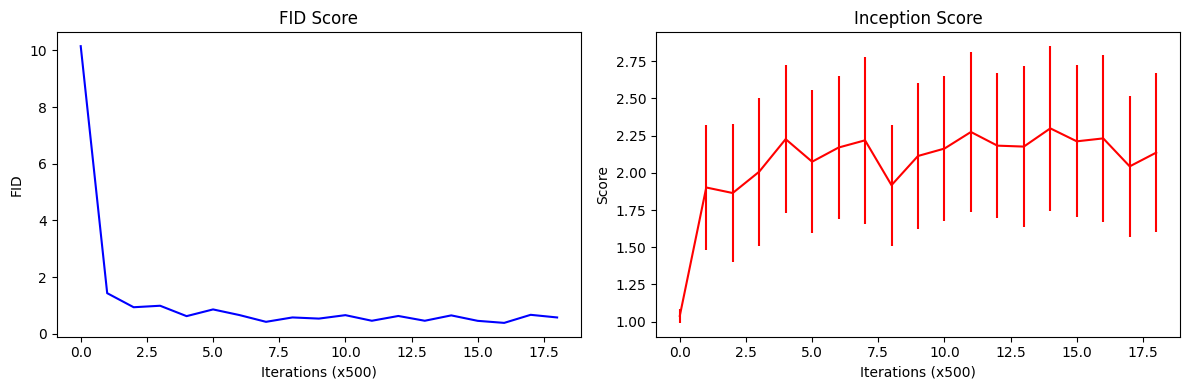

In [13]:
# Avoid the kernel break down
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Before plotting metrics, convert any GPU tensors to CPU numpy arrays
fid_scores = [score.cpu().item() if torch.is_tensor(score) else score for score in fid_scores]
inception_means = [score.cpu().item() if torch.is_tensor(score) else score for score in inception_means]
inception_stds = [score.cpu().item() if torch.is_tensor(score) else score for score in inception_stds]

# After training, plot metrics safely
try:
    plt.figure(figsize=(12, 4))
    
    # Plot in smaller chunks
    steps = range(0, len(fid_scores))
    
    # Plot 1: FID Score
    plt.subplot(1, 2, 1)
    plt.plot(steps, fid_scores, 'b-')
    plt.title('FID Score')
    plt.xlabel('Iterations (x500)')
    plt.ylabel('FID')
    
    # Plot 2: Inception Score with error bars
    plt.subplot(1, 2, 2)
    plt.errorbar(steps, inception_means, yerr=inception_stds, fmt='r-')
    plt.title('Inception Score')
    plt.xlabel('Iterations (x500)')
    plt.ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    plt.close()  # Important to free memory
    
except Exception as e:
    print(f"Error during plotting: {e}")
    print("FID scores:", fid_scores[:5], "...")  # Print first few values
    print("IS means:", inception_means[:5], "...")

This code tracks and visualizes various metrics to evaluate GAN training performance:

### Generator and Discriminator Losses
- The **generator loss** (blue line) starts high and gradually decreases over time, indicating the generator is learning to produce better quality images.
- The **discriminator loss** (orange line) remains relatively stable with slight fluctuations, suggesting that the discriminator is consistently effective in distinguishing real images from generated ones.

### G/D Loss Ratio
- The **Generator/Discriminator (G/D) loss ratio** (green line) starts high but drops significantly before stabilizing at lower values.
- A decreasing ratio indicates that the discriminator is initially much stronger than the generator but they eventually balance out.

### Neural Divergence
- The **neural divergence** (magenta line) fluctuates significantly but generally trends downward, indicating an improving similarity between the generated and real data distributions.

### Precision and Recall
- Initially, **precision** (cyan line) and **recall** (yellow line) are unbalanced, which indicates instability in the initialization.
- As training continues, precision and recall values converge around 60%, indicating that the generator has improved and a **balance between quality and diversity** has been reached.
- Achieving balance around 60% suggests that both the generator and discriminator are working in equilibrium. But it also indicate the possiblility of Mode Collapse if they decrease to 50% , a random state.



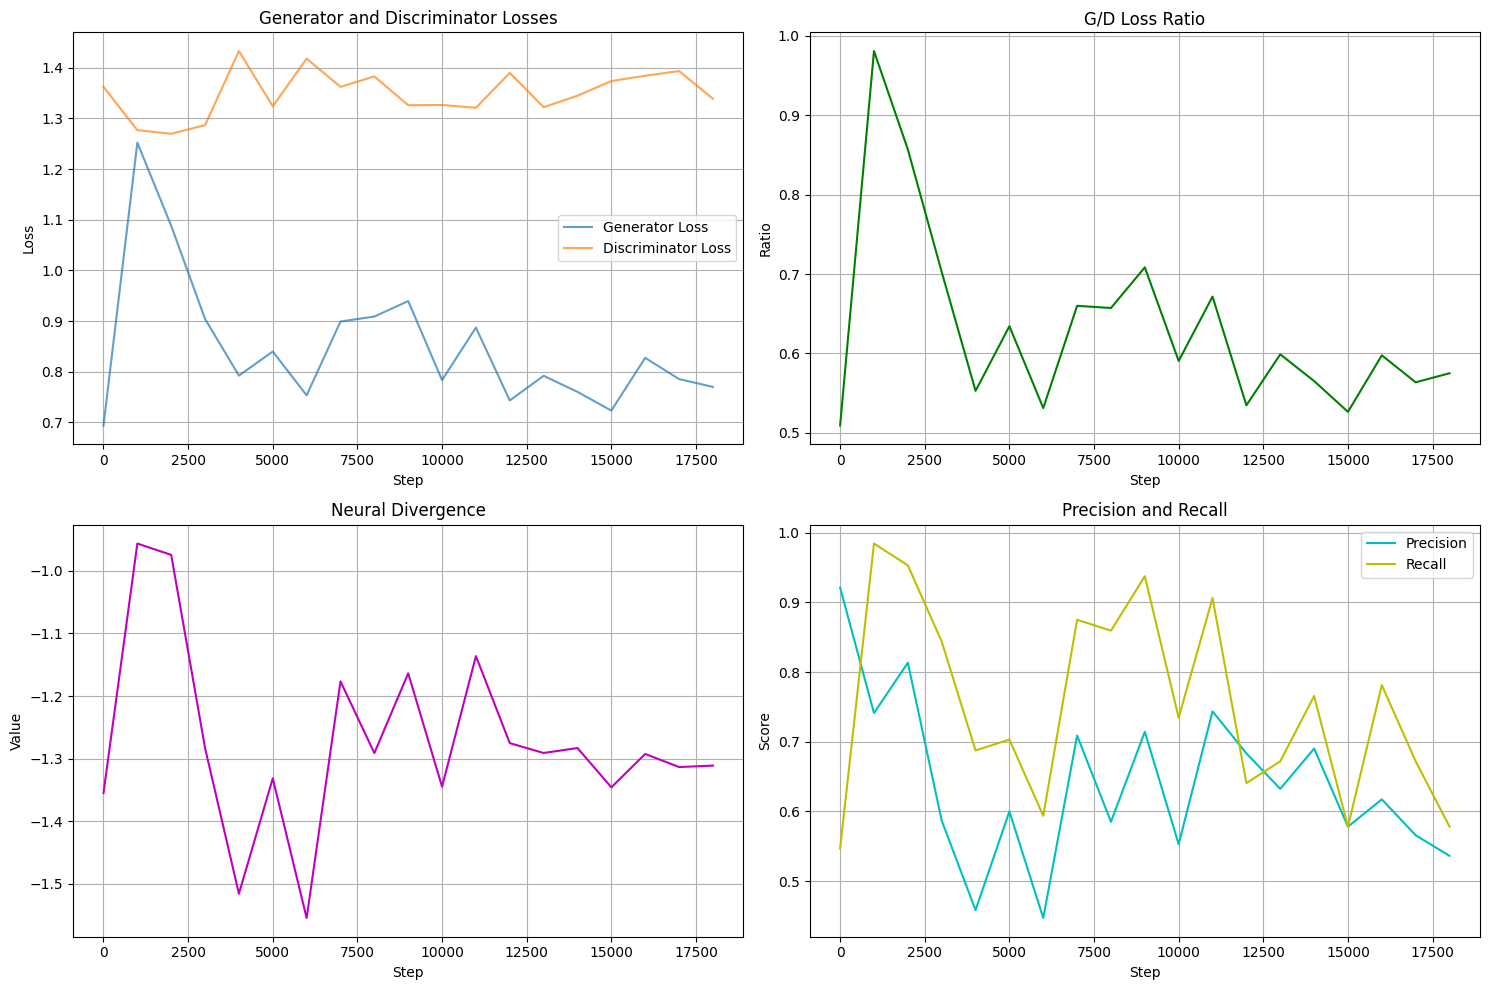

In [14]:
plt.figure(figsize=(15, 10))

# Plot 1: Generator and Discriminator Losses
plt.subplot(2, 2, 1)
plt.plot(range(0, step, 1000), g_losses, label='Generator Loss', alpha=0.7)
plt.plot(range(0, step, 1000), d_losses, label='Discriminator Loss', alpha=0.7)
plt.title('Generator and Discriminator Losses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: G/D Ratio
plt.subplot(2, 2, 2)
plt.plot(range(0, step, 1000), g_d_ratios, 'g-')
plt.title('G/D Loss Ratio')
plt.xlabel('Step')
plt.ylabel('Ratio')
plt.grid(True)

# Plot 3: Neural Divergence
plt.subplot(2, 2, 3)
plt.plot(range(0, step, 1000), neural_divergences, 'm-')
plt.title('Neural Divergence')
plt.xlabel('Step')
plt.ylabel('Value')
plt.grid(True)

# Plot 4: Precision-Recall
plt.subplot(2, 2, 4)
plt.plot(range(0, step, 1000), precisions, 'c-', label='Precision')
plt.plot(range(0, step, 1000), recalls, 'y-', label='Recall')
plt.title('Precision and Recall')
plt.xlabel('Step')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## Generated Images Visualization

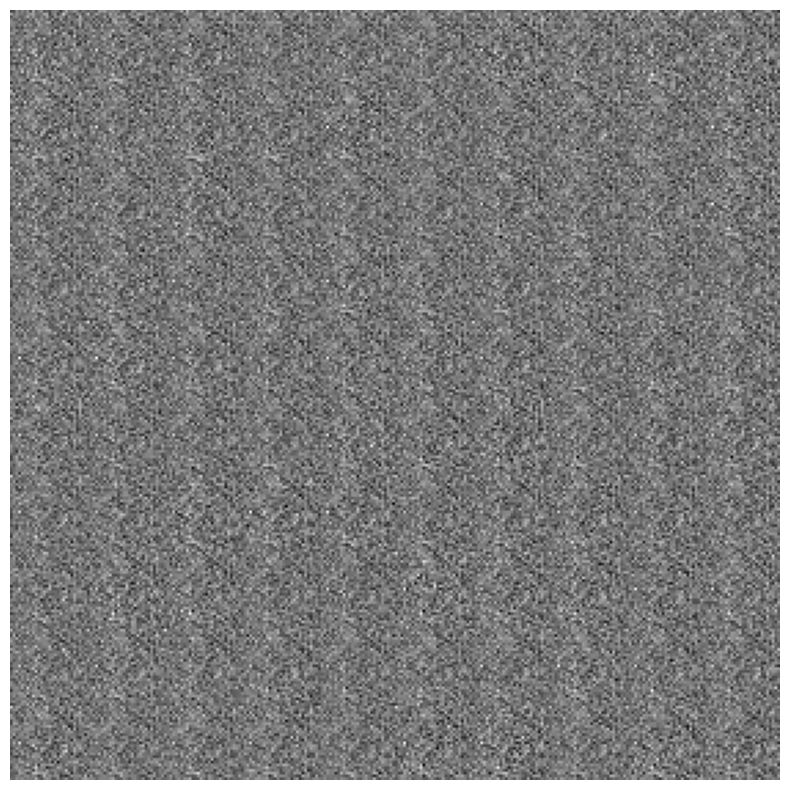

In [15]:
# Display final generated images
img = mpimg.imread(f'samplesGAN/{MODEL_NAME}_step{str(000).zfill(3)}.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

Then it gets better.

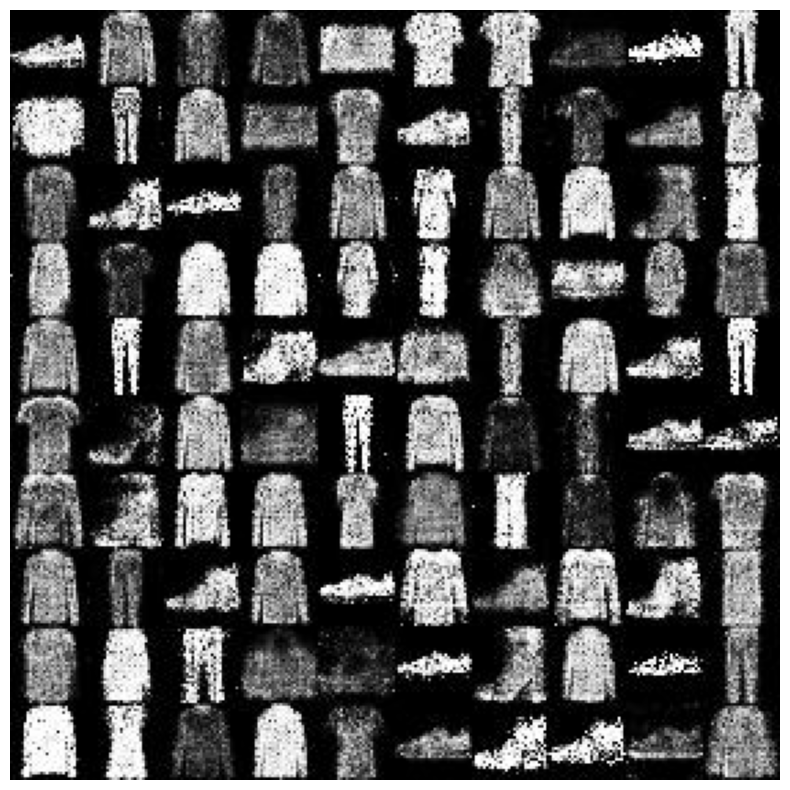

In [16]:
# Display final generated images
img = mpimg.imread(f'samplesGAN/{MODEL_NAME}_step{str(9000).zfill(3)}.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

The final result is clear and seems "realistic" as the images in FashionMNIST after 20 epoches, but we can also find that the image seems to produce a limited variety of outputs and a few classes are repeated.

#### Indication of Mode Collapse
We can find that the generator learns to produce a limited variety of outputs, at the expense of losing the diversity of the data distribution. Instead of capturing all the modes of the real data distribution, the generated image tends to focus on a few classes and repeatedly generates similar outputs.

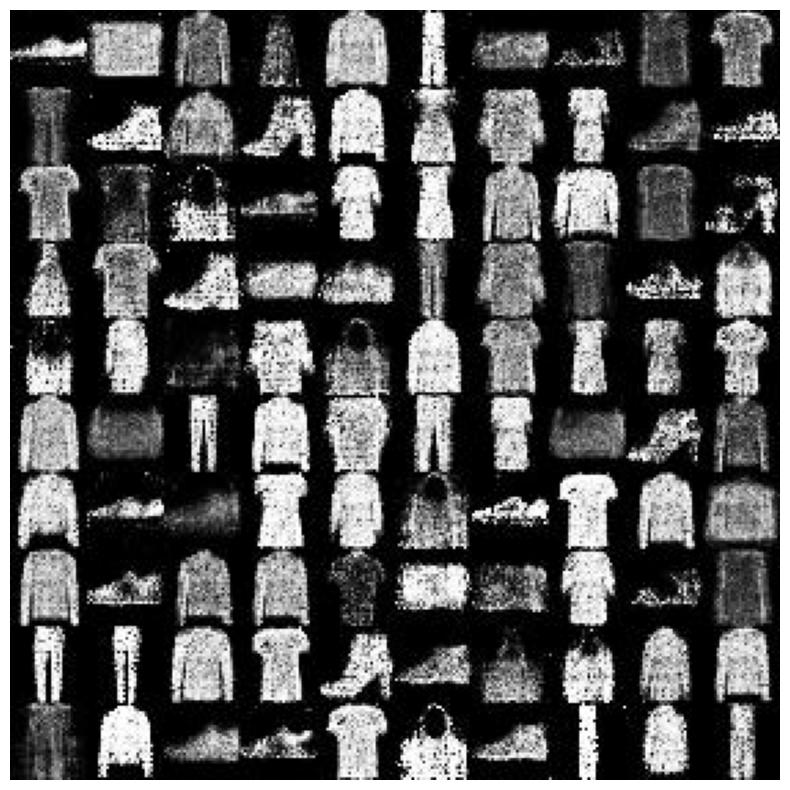

In [17]:
# Display final generated images
img = mpimg.imread(f'samplesGAN/{MODEL_NAME}_step{str(18000).zfill(3)}.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

### Comparison of Fake Image Quality: FashionMNIST GAN vs. MNIST Conditional GAN

#### 1. **Complexity and Quality of the Dataset**
- **FashionMNIST** contains grayscale images of clothing items, which are more complex and feature-rich than the digits in **MNIST**. 
- **MNIST**, with its simpler and more structured patterns (digits 0-9), has higher quality and stability, despite fewer training epochs.

#### 2. **Quality of Fake Images**
- The **FashionMNIST GAN** often struggles to replicate subtle details, leading to artifacts or less-defined features. This is due to the higher complexity of FashionMNIST images.
- The **MNIST Conditional GAN** produces sharper and more recognizable outputs, thanks to the simpler patterns in MNIST and the use of conditional labels to guide generation.

#### 3. **Conditional vs. Unconditional Training**
- The **Conditional GAN** for MNIST benefits from being explicitly conditioned on class labels, which forces the generator to produce images corresponding to specific digits, improving fidelity and reducing ambiguity.
- The standard **FashionMNIST GAN**, if not conditional, lacks this explicit guidance, increasing the likelihood of mode collapse or generating less distinct images.

#### 4. **Mode Coverage**
- The **FashionMNIST GAN** may experience mode collapse, where it repeatedly generates similar images and fails to capture the full diversity of the dataset (e.g., morea about shirts, pants and shoes, less about bags).
- The **Conditional MNIST GAN** avoids this issue by using class labels to ensure all digit classes are represented in the generated images.

#### 5. **Visual Appearance**
- Fake images from the **FashionMNIST GAN** tend to appear "blurry" or lack fine details, reflecting the increased challenge of learning FashionMNIST’s distribution.
- The **MNIST Conditional GAN** generates "blurry" but clearer digit images with well-defined edges.

### Summary
- The **MNIST Conditional GAN** produces higher-quality images due to the simplicity of the dataset and the advantages of conditional training.
- The **FashionMNIST GAN** faces greater difficulty in achieving similar quality althought use twice epochs because of the dataset’s complexity and, if unconditional, the absence of class-label guidance.
